<a href="https://colab.research.google.com/github/Alfonso-Jesus-Garcia-Moya/DL_VISION_COMPUTADORA_TEXTURAS_Y_MATERIALES/blob/main/Semana_12_CON_TAREA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 🧠 1) Utilidades para construir modelos (ResNet50 y MobileNetV2)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50, MobileNetV2
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_pre
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobv2_pre

NUM_CLASSES = 3

def build_classifier(backbone="resnet50", img_size=160, freeze=True, dropout=0.3):
    """
    Crea un modelo Keras con preprocessing propio de la arquitectura.
    backbone: 'resnet50' o 'mobilenetv2'
    """
    inputs = keras.Input(shape=(img_size, img_size, 3), name="image")

    if backbone == "resnet50":
        x = layers.Lambda(resnet_pre, name="preprocess_resnet")(inputs)
        base = ResNet50(include_top=False, input_tensor=x, weights="imagenet")
        last_conv_name = None  # auto-detectaremos abajo
    elif backbone == "mobilenetv2":
        x = layers.Lambda(mobv2_pre, name="preprocess_mobv2")(inputs)
        base = MobileNetV2(include_top=False, input_tensor=x, weights="imagenet")
        last_conv_name = None
    else:
        raise ValueError("backbone debe ser 'resnet50' o 'mobilenetv2'.")

    # Congelar o no la base
    if freeze:
        for l in base.layers:
            l.trainable = False

    y = base.output
    y = layers.GlobalAveragePooling2D(name="gap")(y)
    y = layers.Dropout(dropout)(y)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(y)

    model = keras.Model(inputs, outputs, name=f"{backbone}_clf")
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

def unfreeze_last_n(model, n=40):
    """
    Descongela las últimas n capas entrenables de la base (si existe).
    Útil para fine-tuning.
    """
    count = 0
    for layer in reversed(model.layers):
        if hasattr(layer, "trainable") and not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True
            count += 1
            if count >= n:
                break
    # recompilar con LR más bajo para fine-tuning
    model.compile(
        optimizer=keras.optimizers.Adam(1e-4),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


In [ ]:
# 📂 3) Listado con filtro de *_mask y mapeo imagen→máscara
def is_mask_file(path: str) -> bool:
    """True si el nombre termina con '_mask' antes de la extensión."""
    name = os.path.basename(path).lower()
    stem, _ = os.path.splitext(name)
    return stem.endswith("_mask")

def build_dataset_lists(data_dir: str, exts=(".png", ".jpg", ".jpeg")):
    """
    Devuelve:
      - image_paths: rutas de imágenes reales (sin *_mask.*)
      - mask_paths_map: dict {ruta_imagen -> ruta_mask_o_None}
    """
    image_paths = []
    mask_paths_map = {}
    for cls in ["benign", "malignant", "normal"]:
        cls_dir = os.path.join(data_dir, cls)
        if not os.path.isdir(cls_dir):
            continue
        files = []
        for ext in exts:
            files.extend(glob.glob(os.path.join(cls_dir, f"*{ext}")))
        mask_set = {p for p in files if is_mask_file(p)}
        imgs = [p for p in files if not is_mask_file(p)]
        for img_path in imgs:
            root, ext = os.path.splitext(img_path)
            cand_mask = f"{root}_mask{ext}"
            mask_paths_map[img_path] = cand_mask if cand_mask in mask_set else None
        image_paths.extend(imgs)
    return image_paths, mask_paths_map




# 🧩 Limpieza de anotaciones en imágenes médicas

En esta sección se emplea una **técnica morfológica y de reconstrucción** para eliminar
textos, cruces o líneas que aparecen sobre las imágenes (por ejemplo, en ecografías).  
El objetivo es generar una **máscara binaria** que identifique las zonas con anotaciones
y posteriormente **rellenar esas áreas** utilizando *inpainting* para recuperar la textura original.

---

## ⚙️ 1. Función `inpaint_annotations_v2(gray, mask, radius=6, method="telea")`

- Convierte la imagen en escala de grises (`gray`) a formato **BGR**.
- Usa el algoritmo `cv2.inpaint()` para **reconstruir las regiones marcadas en blanco** dentro de la `mask`.
- El parámetro `radius` controla el tamaño de contexto usado para rellenar.
- `method` puede ser:
  - `"telea"` → rápido y visualmente suave.
  - `"ns"` → método *Navier–Stokes*, más lento pero preserva bordes.

> 🧠 *Resultado:* imagen limpia sin anotaciones, con textura interpolada a partir del entorno.

---

## 🔍 2. Construcción de la máscara de anotaciones

Para detectar los textos, números o cruces, se combinan varias estrategias:

### 🔸 a) **Banco de líneas**  
Se generan kernels morfológicos rotados a 0°, 45°, 90° y 135° para identificar trazos finos (líneas o cruces).
Estas operaciones detectan marcas comunes en ecografías (por ejemplo, cruces de centrado o escalas).

```python
lines_bank = cv2.bitwise_or(
    cv2.bitwise_or(open_with_line(0), open_with_line(90)),
    cv2.bitwise_or(open_with_line(45), open_with_line(135))
)


In [ ]:
# 🧼 4) Detector de anotaciones (v2) + Inpainting (v2) — versión corregida para OpenCV moderno

import cv2
import numpy as np

def build_annotation_mask_v2(
    gray,
    border_fraction=0.12,
    tophat_ks=9,
    bin_thresh_method="otsu",   # "otsu" o "adaptive"
    mser_delta=3,
    mser_min_area=20,
    mser_max_area=2000,
    line_kernel_len=41,
    line_iterations=1,
    area_min_frac=0.0002,
    area_max_frac=0.05,
    center_aggressive=True
):
    """
    Devuelve SIEMPRE una máscara uint8 (H,W) con 0/255.
    Si no hay candidatos, devuelve matriz de ceros del tamaño de gray.
    """
    # 0) Validaciones
    if gray is None or gray.ndim != 2:
        raise ValueError("gray debe ser imagen 2D en escala de grises.")
    g = gray.copy()
    H, W = g.shape
    img_area = H * W

    # 1) Suavizado ligero
    g_blur = cv2.GaussianBlur(g, (3,3), 0)

    # 2) Top-hat (resalta trazos finos claros)
    if tophat_ks % 2 == 0: tophat_ks += 1
    se = cv2.getStructuringElement(cv2.MORPH_RECT, (tophat_ks, tophat_ks))
    top = cv2.morphologyEx(g_blur, cv2.MORPH_TOPHAT, se)

    # 3) Binarización
    if bin_thresh_method == "adaptive":
        th = cv2.adaptiveThreshold(top, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                   cv2.THRESH_BINARY, 15, 2)
    else:
        _, th = cv2.threshold(top, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # 4) Banco de líneas (0°, 45°, 90°, 135°)
    def open_with_line(angle_deg):
        L = line_kernel_len
        ker = np.zeros((L, L), np.uint8)
        cv2.line(ker, (0, L//2), (L-1, L//2), 1, 1)  # horizontal base
        M = cv2.getRotationMatrix2D((L/2, L/2), angle_deg, 1.0)
        k_rot = cv2.warpAffine(ker*255, M, (L, L), flags=cv2.INTER_NEAREST)
        k_rot = (k_rot > 0).astype(np.uint8)
        return cv2.morphologyEx(th, cv2.MORPH_OPEN, k_rot, iterations=line_iterations)

    lines_bank = cv2.bitwise_or(
        cv2.bitwise_or(open_with_line(0), open_with_line(90)),
        cv2.bitwise_or(open_with_line(45), open_with_line(135))
    )

    # 5) MSER para texto fino
    try:
        mser = cv2.MSER_create(delta=mser_delta, min_area=mser_min_area, max_area=mser_max_area)
    except TypeError:
        # Compatibilidad con versiones que usan nombres con guión bajo
        mser = cv2.MSER_create(_delta=mser_delta, _min_area=mser_min_area, _max_area=mser_max_area)
    regions, _ = mser.detectRegions(g_blur)
    mser_mask = np.zeros_like(g, np.uint8)
    for pts in regions:
        hull = cv2.convexHull(pts.reshape(-1, 1, 2))
        cv2.fillConvexPoly(mser_mask, hull, 255)

    # 6) Máscara de bordes
    bf_h, bf_w = int(H*border_fraction), int(W*border_fraction)
    border_mask = np.zeros_like(g, np.uint8)
    if bf_h > 0:
        border_mask[:bf_h, :] = 255
        border_mask[-bf_h:, :] = 255
    if bf_w > 0:
        border_mask[:, :bf_w] = 255
        border_mask[:, -bf_w:] = 255

    center_mask = th if center_aggressive else border_mask

    # 7) Candidatos combinados
    cand = cv2.bitwise_or(lines_bank, mser_mask)
    cand = cv2.bitwise_or(cand, th)
    cand = cv2.bitwise_and(cand, cv2.bitwise_or(border_mask, center_mask))

    # 8) Filtrado por área
    labels_input = (cand > 0).astype(np.uint8)
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(labels_input, connectivity=8)
    out_mask = np.zeros_like(g, np.uint8)

    for i in range(1, num_labels):
        area = int(stats[i, cv2.CC_STAT_AREA])
        if img_area*area_min_frac <= area <= img_area*area_max_frac:
            out_mask[labels == i] = 255

    # 9) Suavizado de contornos
    if np.count_nonzero(out_mask) > 0:
        out_mask = cv2.dilate(out_mask, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3)), iterations=1)

    return out_mask  # <- SIEMPRE devuelve (H,W) uint8


def inpaint_annotations_v2(gray, mask, radius=6, method="telea"):
    """Rellena las zonas marcadas para borrar anotaciones."""
    bgr = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
    flag = cv2.INPAINT_TELEA if method == "telea" else cv2.INPAINT_NS
    out = cv2.inpaint(bgr, mask, radius, flag)
    return cv2.cvtColor(out, cv2.COLOR_BGR2GRAY)

    # Banco de líneas (0°, 45°, 90°, 135°)
    def open_with_line(angle_deg):
        L = line_kernel_len
        kernel = np.zeros((L, L), np.uint8)
        cv2.line(kernel, (0, L//2), (L-1, L//2), 1, 1)  # horizontal base
        M = cv2.getRotationMatrix2D((L/2, L/2), angle_deg, 1.0)
        k_rot = cv2.warpAffine(kernel*255, M, (L, L), flags=cv2.INTER_NEAREST)
        k_rot = (k_rot > 0).astype(np.uint8)
        return cv2.morphologyEx(th, cv2.MORPH_OPEN, k_rot, iterations=line_iterations)

    lines_bank = cv2.bitwise_or(
        cv2.bitwise_or(open_with_line(0), open_with_line(90)),
        cv2.bitwise_or(open_with_line(45), open_with_line(135))
    )

    # MSER para texto fino (LT9, numeritos)
    mser = cv2.MSER_create(delta=mser_delta, min_area=mser_min_area, max_area=mser_max_area)
    regions, _ = mser.detectRegions(g)
    mser_mask = np.zeros_like(g, np.uint8)
    for pts in regions:
        hull = cv2.convexHull(pts.reshape(-1, 1, 2))
        cv2.fillConvexPoly(mser_mask, hull, 255)

    # Máscara de borde
    bf_h, bf_w = int(h*border_fraction), int(w*border_fraction)
    border_mask = np.zeros_like(g, np.uint8)
    border_mask[:bf_h, :] = 255; border_mask[-bf_h:, :] = 255
    border_mask[:, :bf_w] = 255; border_mask[:, -bf_w:] = 255

    center_mask = th if center_aggressive else border_mask

    # Candidatos combinados
    cand = cv2.bitwise_or(lines_bank, mser_mask)
    cand = cv2.bitwise_or(cand, th)
    cand = cv2.bitwise_and(cand, cv2.bitwise_or(border_mask, center_mask))

    # Filtrado por área
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats((cand > 0).astype(np.uint8), connectivity=8)
    mask = np.zeros_like(g, np.uint8)
    for i in range(1, num_labels):
        area = stats[i, cv2.CC_STAT_AREA]
        if img_area*area_min_frac <= area <= img_area*area_max_frac:
            mask[labels == i] = 255

    # Suaviza bordes de la región a inpaint
    mask = cv2.dilate(mask, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3)), iterations=1)
    return mask


In [ ]:
def fallback_border_mask(gray, border_fraction=0.10):
    H, W = gray.shape
    bf_h, bf_w = int(H*border_fraction), int(W*border_fraction)
    m = np.zeros_like(gray, np.uint8)
    if bf_h > 0:
        m[:bf_h, :] = 255; m[-bf_h:, :] = 255
    if bf_w > 0:
        m[:, :bf_w] = 255; m[:, -bf_w:] = 255
    return m


| Etapa                      | Propósito                                   | Resultado     |
| -------------------------- | ------------------------------------------- | ------------- |
| **1. Líneas (morph open)** | Detectar cruces o líneas anotadas           | `lines_bank`  |
| **2. MSER**                | Capturar letras/números                     | `mser_mask`   |
| **3. Borde**               | Delimitar zonas típicas de texto            | `border_mask` |
| **4. Combinación**         | Unir líneas + texto + bordes                | `cand`        |
| **5. Filtrado**            | Quitar ruido y mantener áreas válidas       | `mask`        |
| **6. Inpainting**          | Rellenar esas zonas con textura circundante | `gray_clean`  |


In [ ]:
# ✂️ 5) Estandarización robusta (recorte + CLAHE + resize con aspecto)
def auto_crop_black_borders_v2(gray, border_margin=3, dynamic=True):
    """
    Recorta márgenes oscuros/monótonos en ecografías.
    Umbral dinámico según brillo global para mayor robustez.
    """
    g = gray.copy().astype(np.uint8)
    if dynamic:
        mean_intensity = np.mean(g)
        thresh_val = max(5, mean_intensity * 0.2)
    else:
        thresh_val = 5
    _, bin_img = cv2.threshold(g, thresh_val, 255, cv2.THRESH_BINARY)
    bin_img = cv2.morphologyEx(bin_img, cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8))
    coords = cv2.findNonZero(bin_img)
    if coords is None:
        return g
    x, y, w, h = cv2.boundingRect(coords)
    y0 = max(y - border_margin, 0); y1 = min(y + h + border_margin, g.shape[0])
    x0 = max(x - border_margin, 0); x1 = min(x + w + border_margin, g.shape[1])
    return g[y0:y1, x0:x1]

def standardize_gray_v2(gray, img_size=224, clahe_clip=2.0, preserve_ratio=True):
    """
    Limpia bordes, realza textura con CLAHE y redimensiona.
    preserve_ratio=True aplica padding negro para mantener aspecto original.
    """
    cropped = auto_crop_black_borders_v2(gray)
    clahe = cv2.createCLAHE(clipLimit=clahe_clip, tileGridSize=(8, 8))
    g = clahe.apply(cropped).astype(np.float32)
    mn, mx = np.percentile(g, 1), np.percentile(g, 99)
    g = np.clip((g - mn) / (mx - mn + 1e-6), 0, 1)
    g = (g * 255).astype(np.uint8)
    if preserve_ratio:
        h, w = g.shape
        scale = img_size / max(h, w)
        new_h, new_w = int(h * scale), int(w * scale)
        resized = cv2.resize(g, (new_w, new_h), interpolation=cv2.INTER_AREA)
        canvas = np.zeros((img_size, img_size), dtype=np.uint8)
        y_off, x_off = (img_size - new_h) // 2, (img_size - new_w) // 2
        canvas[y_off:y_off+new_h, x_off:x_off+new_w] = resized
        return canvas
    else:
        return cv2.resize(g, (img_size, img_size), interpolation=cv2.INTER_AREA)


In [ ]:
# 🖼️ 2) Utilidades de gráficas
def show_side_by_side(img1, img2, title1="Original", title2="Procesada", cmap="gray"):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1); plt.imshow(img1, cmap=cmap); plt.title(title1); plt.axis("off")
    plt.subplot(1,2,2); plt.imshow(img2, cmap=cmap); plt.title(title2); plt.axis("off")
    plt.tight_layout(); plt.show()

def show_triplet(img1, img2, img3, t1="Original", t2="Máscara", t3="Limpia", cmap="gray"):
    plt.figure(figsize=(15,4))
    plt.subplot(1,3,1); plt.imshow(img1, cmap=cmap); plt.title(t1); plt.axis("off")
    plt.subplot(1,3,2); plt.imshow(img2, cmap=cmap); plt.title(t2); plt.axis("off")
    plt.subplot(1,3,3); plt.imshow(img3, cmap=cmap); plt.title(t3); plt.axis("off")
    plt.tight_layout(); plt.show()


In [ ]:
def apply_roi_with_mask(gray, mask_path, dilate_px=5):
    """Restringe la imagen a la ROI de la máscara; rellena fuera con negro."""
    if mask_path is None or not os.path.isfile(mask_path):
        return gray
    m = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if m is None or m.shape != gray.shape:
        return gray
    if dilate_px > 0:
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (dilate_px, dilate_px))
        m = cv2.dilate(m, kernel, iterations=1)
    # normalizar máscara a 0/1
    m_bin = (m > 0).astype(np.uint8)
    roi = gray * m_bin + 0 * (1 - m_bin)
    return roi


In [ ]:
# 🚀 7) Pipeline completo — listo para usar
def preprocess_pipeline(path, img_size=224, border_fraction=0.12, rgb_out=True):
    """
    1) Lee en gris
    2) (Opcional) Aplica ROI con máscara (*_mask) si USE_ROI_MASK=True
    3) Detecta anotaciones y hace inpainting (v2)
    4) Estandariza (recorte, CLAHE, resize con aspecto) (v2)
    5) Devuelve RGB (3 canales) o 1 canal
    """
    gray = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if gray is None:
        raise FileNotFoundError(f"No se pudo leer la imagen: {path}")

    if USE_ROI_MASK:
        roi_mask_path = IMAGE_TO_MASK.get(path, None)
        gray = apply_roi_with_mask(gray, roi_mask_path, dilate_px=5)

    annot_mask = build_annotation_mask_v2(
        gray,
        border_fraction=border_fraction,
        tophat_ks=9,
        bin_thresh_method="otsu",
        line_kernel_len=41,
        line_iterations=1,
        center_aggressive=True
    )
    clean = inpaint_annotations_v2(gray, annot_mask, radius=6, method="telea")
    std = standardize_gray_v2(clean, img_size=img_size, preserve_ratio=True)

    if rgb_out:
        return np.stack([std, std, std], axis=-1)
    else:
        return std


In [ ]:
# 🔎 3) Verificación rápida — muestra aleatoria por clase (post-procesado)
import random, matplotlib.pyplot as plt

def show_random_grid(out_dir, per_class=4):
    fig, axes = plt.subplots(len(CLASSES), per_class, figsize=(3*per_class, 3*len(CLASSES)))
    if len(CLASSES) == 1:
        axes = np.array([axes])
    for i, cls in enumerate(CLASSES):
        cls_dir = os.path.join(out_dir, cls)
        files = [os.path.join(cls_dir, f) for f in os.listdir(cls_dir) if f.lower().endswith(".png")]
        if not files:
            continue
        sample = random.sample(files, min(per_class, len(files)))
        for j in range(per_class):
            ax = axes[i, j] if per_class > 1 else axes[i, 0]
            if j < len(sample):
                img = cv2.cvtColor(cv2.imread(sample[j]), cv2.COLOR_BGR2RGB)
                ax.imshow(img); ax.set_title(cls); ax.axis("off")
            else:
                ax.axis("off")
    plt.tight_layout(); plt.show()

In [ ]:
# 🧩 === Bloque completo para modelos texturales ===
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# ----- Capas personalizadas -----
class GeMPooling(layers.Layer):
    """Generalized Mean Pooling (GeM) — resalta patrones tipo textura"""
    def __init__(self, p_init=3.0, eps=1e-6, **kw):
        super().__init__(**kw)
        self.p = tf.Variable(p_init, trainable=True, dtype=tf.float32)
        self.eps = eps
    def call(self, x):
        x = tf.clip_by_value(x, self.eps, tf.reduce_max(x))
        x = tf.pow(x, self.p)
        x = tf.reduce_mean(x, axis=[1,2])
        x = tf.pow(x, 1.0/self.p)
        return x

class BilinearPooling(layers.Layer):
    """Bilinear Pooling — captura co-ocurrencias de texturas"""
    def call(self, x):
        B = tf.shape(x)[0]
        x = tf.reshape(x, [B, -1, x.shape[-1]])  # (B,HW,C)
        phi = tf.matmul(x, x, transpose_a=True) / tf.cast(tf.shape(x)[1], tf.float32)  # (B,C,C)
        y = tf.sign(phi) * tf.sqrt(tf.abs(phi) + 1e-9)
        y = tf.nn.l2_normalize(tf.reshape(y, [B, -1]), axis=-1)
        return y

# ----- Constructor del modelo -----
def build_texture_classifier(backbone="resnet50", head="gem", num_classes=3,
                             img_size=160, freeze=True):
    """
    Crea un modelo con cabeza GeM o Bilinear para enfatizar textura.
    """
    from tensorflow.keras.applications import ResNet50, MobileNetV2
    from tensorflow.keras.applications.resnet50 import preprocess_input as res_pre
    from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mob_pre

    inputs = keras.Input((img_size, img_size, 3))
    if backbone == "resnet50":
        x = layers.Lambda(res_pre)(inputs)
        base = ResNet50(include_top=False, input_tensor=x, weights="imagenet")
    else:
        x = layers.Lambda(mob_pre)(inputs)
        base = MobileNetV2(include_top=False, input_tensor=x, weights="imagenet")

    if freeze:
        for l in base.layers:
            l.trainable = False

    feat = base.output
    if head == "gem":
        x = GeMPooling(name="gem")(feat)
    elif head == "bilinear":
        x = BilinearPooling(name="bilinear")(feat)
    else:
        x = layers.GlobalAveragePooling2D(name="gap")(feat)

    x = layers.Dropout(0.3)(x)
    out = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs, out, name=f"{backbone}_{head}")
    model.compile(optimizer=keras.optimizers.Adam(1e-3),
                  loss="categorical_crossentropy", metrics=["accuracy"])
    return model


# 🧭 Tema 5 · Materiales y Texturas (Visión por Computadora con CNN)

## 🎯 Objetivo
Comprender **qué son los materiales y las texturas**, por qué son importantes en visión por computadora,  
y cómo las **redes neuronales convolucionales (CNN)** aprenden patrones de apariencia útiles para tareas de **clasificación, segmentación y detección de defectos**.

---

## 🔹 Conceptos clave

### 🧩 Material
Propiedad física de una superficie (madera, metal, piel, tela).  
Define cómo **refleja la luz** (brillo, color, especularidad) y su **microgeometría**.

### 🌀 Textura
Patrón visual repetitivo o aleatorio que resulta de la **interacción entre la luz y la superficie**.  
Incluye características como **rugosidad, orientación, frecuencia y contraste local**.

> 💡 En resumen: el **material** es *qué es* la superficie; la **textura** es *cómo se ve* ese material.

---

## ⚙️ Importancia práctica

| Área | Aplicación | Ejemplo |
|------|-------------|----------|
| 🏭 Industria | Control de calidad | Detectar rayaduras o irregularidades en metal o plástico |
| 🩺 Medicina | Diagnóstico por imágenes | Identificar cambios de textura en piel o tejidos |
| 🤖 Robótica | Manipulación de objetos | Ajustar agarre según rugosidad o tipo de material |
| 🌍 Geociencias | Clasificación de suelos/rocas | Distinguir texturas arenosas, arcillosas o graníticas |

---

## 🧠 ¿Cómo “ven” las CNN las texturas?

1. **Capas iniciales** → detectan bordes, líneas y frecuencias.
2. **Capas intermedias** → combinan patrones locales repetitivos.
3. **Capas profundas** → resumen la apariencia general (*qué tan “maderosa”, “metálica” o “áspera” luce*).
4. **Pooling y normalización** → ayudan a que el modelo sea robusto a iluminación, escala y orientación.

---

## 🧩 Técnicas especializadas en texturas

- **Bilinear pooling:** combina activaciones para capturar co-ocurrencias de filtros (texturas finas).  
- **GeM pooling:** pooling adaptable entre promedio y máximo.  
- **SE / CBAM:** atención canal-espacial que realza zonas relevantes.  
- **Instance Normalization:** separa contenido y estilo, útil ante cambios de iluminación.

---

## ⚡ Retos y buenas prácticas

- 💡 **Iluminación:** usar *augmentation* de brillo y contraste.  
- 🔁 **Escala:** usar parches o imágenes multi-escala.  
- 🔄 **Orientación:** aplicar rotaciones y volteos aleatorios.  
- ⚖️ **Balance:** revisar distribución de clases o aplicar *class weights*.  
- 🧭 **Contexto:** decidir si el modelo debe centrarse en la textura o también en la forma.

---

## 🔬 Ejemplos rápidos

- Metal **pulido vs. cepillado** → mismo material, texturas diferentes.  
- Piel **sana vs. lesionada** → textura cambia con el estado del tejido.  
- Tela **denim vs. lino** → la frecuencia y orientación del tejido determinan su textura.

---

## ✏️ Mini-actividad

1. Define **material** y **textura** con tus propias palabras.  
2. Da un ejemplo real donde la **textura** sea más informativa que la forma.  
3. Propón un *augmentation* para mejorar un modelo que detecte **rayaduras** en aluminio.

---

## 📚 Glosario básico

| Término | Definición |
|----------|-------------|
| **Albedo** | Color intrínseco de la superficie, sin efecto de luz. |
| **BRDF** | Describe cómo una superficie refleja la luz. |
| **Frecuencias** | Cambios finos o gruesos en la imagen. |
| **Co-ocurrencia** | Aparición conjunta de patrones; base del *bilinear pooling*. |

---




In [ ]:
from google.colab import drive


drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 🧭 Materiales y Texturas — Preprocesamiento en Ecografías (BUSI_with_GT)

**Objetivo:** limpiar anotaciones (texto, cruces, líneas) de las ecografías, estandarizar tamaño/contraste y preparar imágenes enfocadas en **textura** del tejido.

**Pipeline:**
1) Filtrado de archivos `*_mask` (solo imágenes reales).  
2) Detección de anotaciones (Top-hat + banco de líneas + MSER) → **máscara**.  
3) **Inpainting** para borrar anotaciones.  
4) Recorte de bordes oscuros + **CLAHE** + *resize* con aspecto.  
5) (Opcional) ROI con máscara de lesión (centrar textura de la lesión).  



In [ ]:
import zipfile
import os

zip_drive_path = "/content/drive/MyDrive/A105 RECONOCIMIENTO DE FORMAS Y APRENDIZAJE COMPUTACIONAL /Clases/Semana 12/Dataset_BUSI_with_GT.zip"
#zip_drive_path = "/content/drive/MyDrive/A105 RECONOCIMIENTO DE FORMAS Y APRENDIZAJE COMPUTACIONAL /Clases/Semana 12/Oral Cancer.zip"
dataset_extract_path = "/content/"

# Crear carpeta de extracción
os.makedirs(dataset_extract_path, exist_ok=True)

# Descomprimir directamente desde Drive
with zipfile.ZipFile(zip_drive_path, 'r') as zip_ref:
    zip_ref.extractall(dataset_extract_path)

print("Archivos extraídos en:", dataset_extract_path)
!ls "/content/Dataset_BUSI_with_GT"

Archivos extraídos en: /content/
benign	malignant  normal


In [ ]:
# ⬇️ 1) Setup básico
from pathlib import Path
import os, glob, re
import cv2, numpy as np
import matplotlib.pyplot as plt

# Ruta al dataset (ajusta si tu carpeta tiene otro nombre o está en otra ubicación)
# Estructura esperada:
# /content/Dataset_BUSI_with_GT/
#   benign/
#   malignant/
#   normal/
DATA_DIR = "/content/Dataset_BUSI_with_GT"  # <-- AJUSTA

# Parámetros globales
IMG_SIZE = 160
BORDER_FRACTION = 0.12  # fracción del borde donde suelen estar anotaciones
USE_ROI_MASK = False    # True: limita la imagen a la lesión usando *_mask si existe

print("OpenCV:", cv2.__version__)


OpenCV: 4.12.0


In [ ]:
IMAGE_PATHS, IMAGE_TO_MASK = build_dataset_lists(DATA_DIR)
print(f"Total imágenes (sin máscaras): {len(IMAGE_PATHS)}")
print("Ejemplo:", IMAGE_PATHS[0] if IMAGE_PATHS else "N/A")
print("Su máscara:", IMAGE_TO_MASK.get(IMAGE_PATHS[0], None) if IMAGE_PATHS else "N/A")

Total imágenes (sin máscaras): 798
Ejemplo: /content/Dataset_BUSI_with_GT/benign/benign (256).png
Su máscara: /content/Dataset_BUSI_with_GT/benign/benign (256)_mask.png


In [ ]:
# 🔎 8) Buscar por nombre — p.ej. "benign (1)"
def find_image_by_name(name_fragment, data_dir=DATA_DIR, exts=(".png", ".jpg", ".jpeg")):
    pattern = re.compile(re.escape(name_fragment), re.IGNORECASE)
    for root, _, files in os.walk(data_dir):
        for f in files:
            if is_mask_file(f):
                continue
            if f.lower().endswith(exts) and pattern.search(f):
                return os.path.join(root, f)
    return None

# Ejemplo:
target_name = "benign (6)"   # cambia para probar otros
img_path = find_image_by_name(target_name)
print("Encontrada:", img_path)


Encontrada: /content/Dataset_BUSI_with_GT/benign/benign (6).png


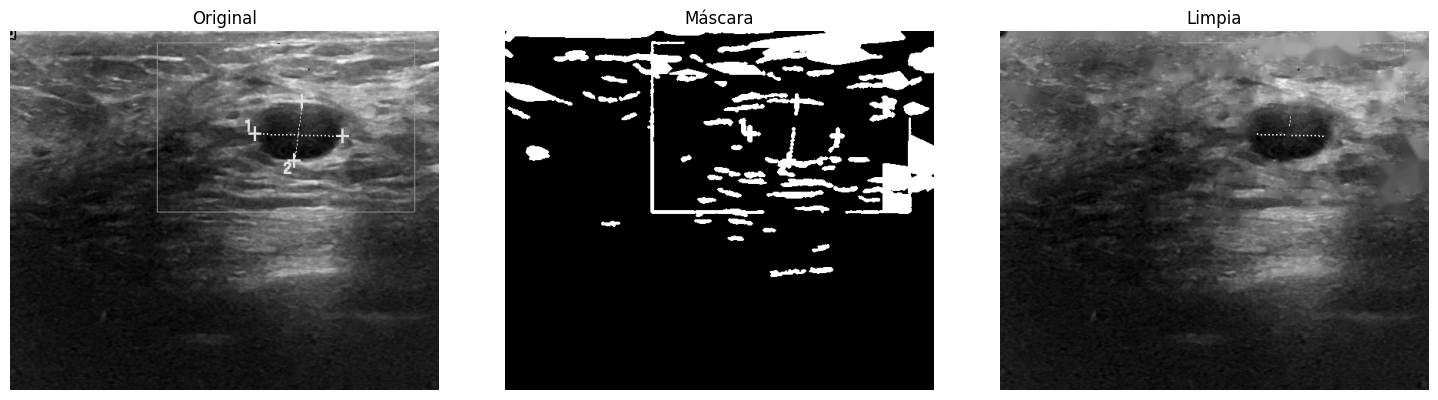

In [ ]:
gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
mask = build_annotation_mask_v2(gray, line_kernel_len=41, center_aggressive=True)

# Si la máscara viene vacía, aplica fallback (opcional)
if mask is None or np.count_nonzero(mask) == 0:
    print("⚠️ Mask vacía: aplicando fallback de bordes.")
    mask = fallback_border_mask(gray, border_fraction=0.10)

clean = inpaint_annotations_v2(gray, mask, radius=6, method="telea")
show_triplet(gray, mask, clean, t1="Original", t2="Máscara", t3="Limpia")


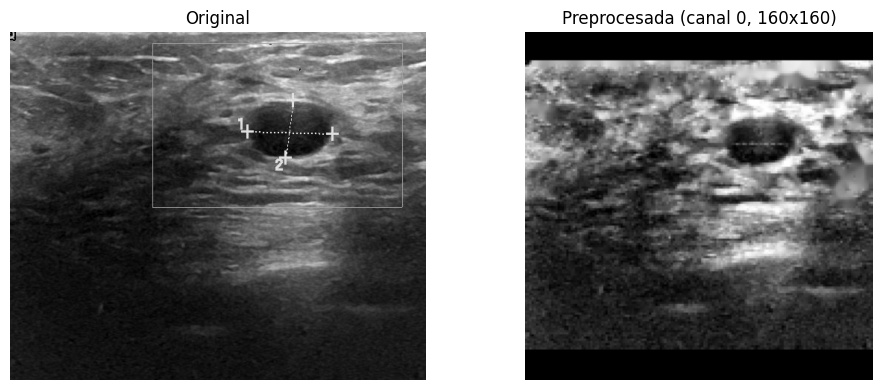

In [ ]:
# 🧪 10) Demo pipeline completo — estandarización y RGB (lista para CNN)
if img_path is not None:
    out_rgb = preprocess_pipeline(img_path, img_size=IMG_SIZE, border_fraction=BORDER_FRACTION, rgb_out=True)
    original = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    show_side_by_side(original, out_rgb[...,0], "Original", f"Preprocesada (canal 0, {IMG_SIZE}x{IMG_SIZE})")
else:
    print("Ajusta 'target_name' o usa un path directo a una imagen.")


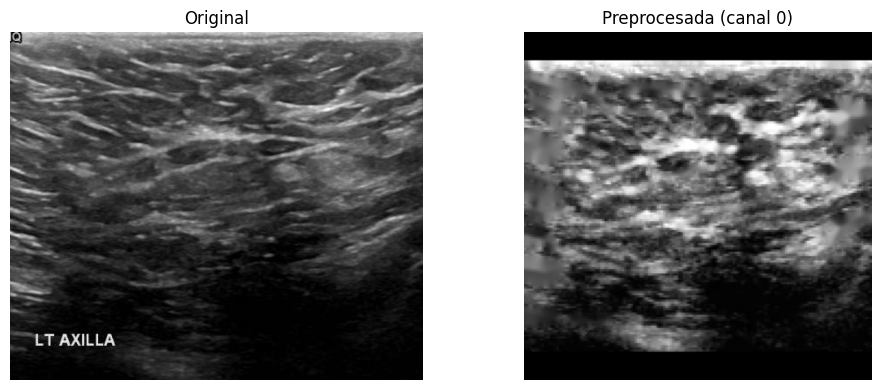

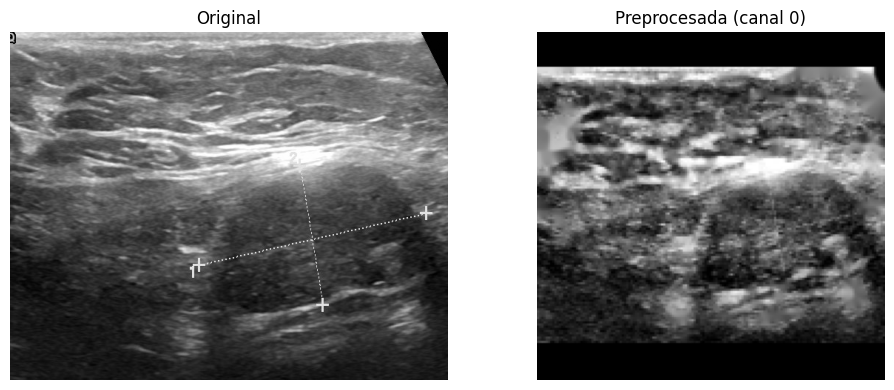

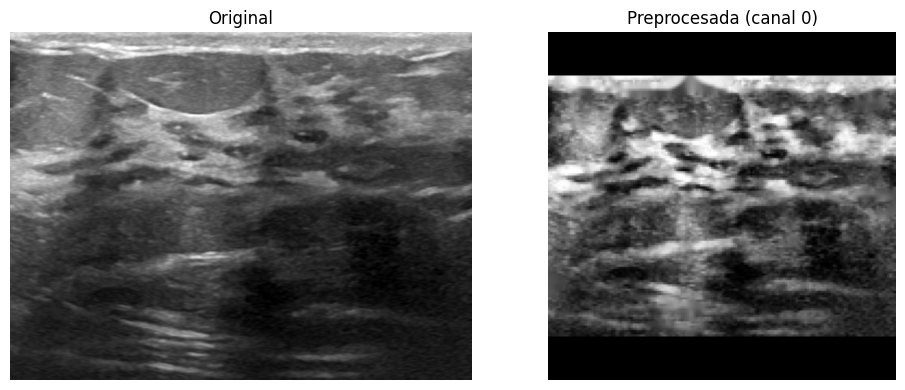

In [ ]:
# 🧪 11) Demo en lote — primeras 3 imágenes del conjunto
sample_paths = IMAGE_PATHS[:3]
for p in sample_paths:
    out = preprocess_pipeline(p, img_size=IMG_SIZE, border_fraction=BORDER_FRACTION, rgb_out=True)
    original = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
    show_side_by_side(original, out[..., 0], "Original", "Preprocesada (canal 0)")


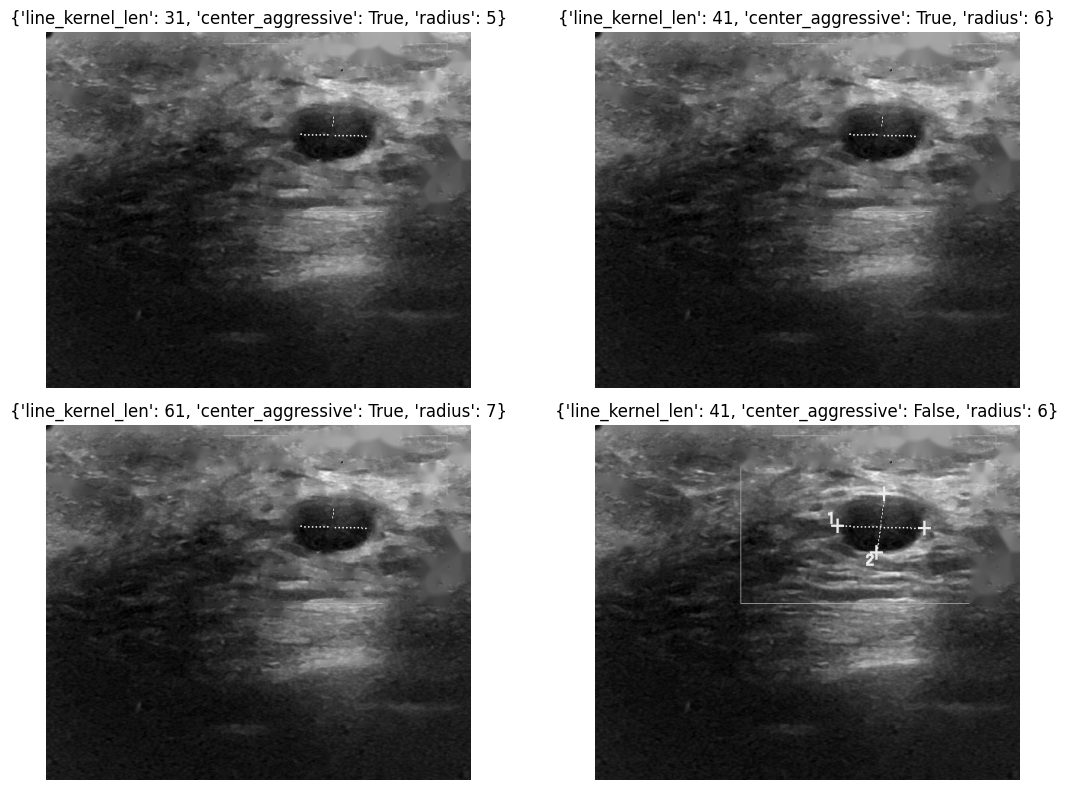

In [ ]:
# 🧪 12) (Opcional) Comparador 2x2 — prueba rápida de parámetros
def compare_presets(gray):
    # Lista de configuraciones predefinidas (presets) para un procesamiento,
    # Detección o filtrado de líneas, bordes o estructuras similares.
    presets = [
        dict(line_kernel_len=31, center_aggressive=True,  radius=5),  # Núcleo de línea de longitud 31, modo agresivo activado, radio de 5
        dict(line_kernel_len=41, center_aggressive=True,  radius=6),  # Núcleo más largo (41), aún agresivo, radio de 6
        dict(line_kernel_len=61, center_aggressive=True,  radius=7),  # Núcleo aún más largo (61), modo agresivo, radio de 7
        dict(line_kernel_len=41, center_aggressive=False, radius=6),  # Igual que el segundo, pero modo no agresivo (más suave)
    ]
    results, titles = [], []
    for ps in presets:
        m = build_annotation_mask_v2(
            gray, line_kernel_len=ps["line_kernel_len"],
            center_aggressive=ps["center_aggressive"]
        )
        c = inpaint_annotations_v2(gray, m, radius=ps["radius"])
        results.append(c); titles.append(str(ps))
    plt.figure(figsize=(12,8))
    for i,(img,t) in enumerate(zip(results,titles)):
        plt.subplot(2,2,i+1); plt.imshow(img, cmap="gray"); plt.title(t); plt.axis("off")
    plt.tight_layout(); plt.show()

# Ejecutar comparador (si se definió img_path)
if img_path is not None:
    g = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    compare_presets(g)


In [ ]:
# ⚙️ 1) Configurar carpeta de salida y helpers
import os, csv, cv2, numpy as np
from pathlib import Path
from tqdm import tqdm

OUT_DIR = f"/content/processed_BUSI_{IMG_SIZE}"   # <- cambia si deseas otra carpeta
os.makedirs(OUT_DIR, exist_ok=True)

# Crear subcarpetas por clase si existen en origen
CLASSES = []
for cls in ["benign", "malignant", "normal"]:
    in_dir = os.path.join(DATA_DIR, cls)
    if os.path.isdir(in_dir):
        os.makedirs(os.path.join(OUT_DIR, cls), exist_ok=True)
        CLASSES.append(cls)

print("Clases detectadas:", CLASSES)
print("Salida:", OUT_DIR)


Clases detectadas: ['benign', 'malignant', 'normal']
Salida: /content/processed_BUSI_160


In [ ]:
# 🏃 2) Procesar TODO y guardar imágenes (PNG 8-bit, RGB) + manifiesto CSV
manifest_path = os.path.join(OUT_DIR, "manifest.csv")
fields = ["orig_path", "out_path", "label", "has_mask", "roi_used", "img_size"]

processed_count = 0
errors = []

with open(manifest_path, "w", newline="") as fcsv:
    writer = csv.DictWriter(fcsv, fieldnames=fields)
    writer.writeheader()

    for in_path in tqdm(IMAGE_PATHS, desc="Procesando imágenes"):
        try:
            # Determinar etiqueta (carpeta padre)
            label = Path(in_path).parent.name
            if label not in CLASSES:
                # Si falta la carpeta (caso raro), coloca en raíz
                out_dir = OUT_DIR
            else:
                out_dir = os.path.join(OUT_DIR, label)

            # Procesar
            out_rgb = preprocess_pipeline(
                in_path, img_size=IMG_SIZE,
                border_fraction=BORDER_FRACTION, rgb_out=True
            )  # (H,W,3) uint8

            # Asegurar tipo/forma
            if out_rgb.dtype != np.uint8:
                out_rgb = np.clip(out_rgb, 0, 255).astype(np.uint8)

            # Nombre de salida (mismo nombre base)
            fname = os.path.basename(in_path)
            stem, _ = os.path.splitext(fname)
            out_name = stem + ".png"
            out_path = os.path.join(out_dir, out_name)

            # Guardar
            cv2.imwrite(out_path, cv2.cvtColor(out_rgb, cv2.COLOR_RGB2BGR))

            # Registrar en manifiesto
            has_mask = IMAGE_TO_MASK.get(in_path, None) is not None
            writer.writerow({
                "orig_path": in_path,
                "out_path": out_path,
                "label": label,
                "has_mask": int(has_mask),
                "roi_used": int(USE_ROI_MASK),
                "img_size": IMG_SIZE
            })
            processed_count += 1

        except Exception as e:
            errors.append((in_path, str(e)))

print(f"✅ Procesadas: {processed_count} | ❌ Errores: {len(errors)}")
if errors:
    print("Ejemplos de error (máx 3):")
    for p, msg in errors[:3]:
        print(" -", p, "->", msg)
print("Manifiesto:", manifest_path)


Procesando imágenes: 100%|██████████| 798/798 [05:20<00:00,  2.49it/s]

✅ Procesadas: 798 | ❌ Errores: 0
Manifiesto: /content/processed_BUSI_160/manifest.csv


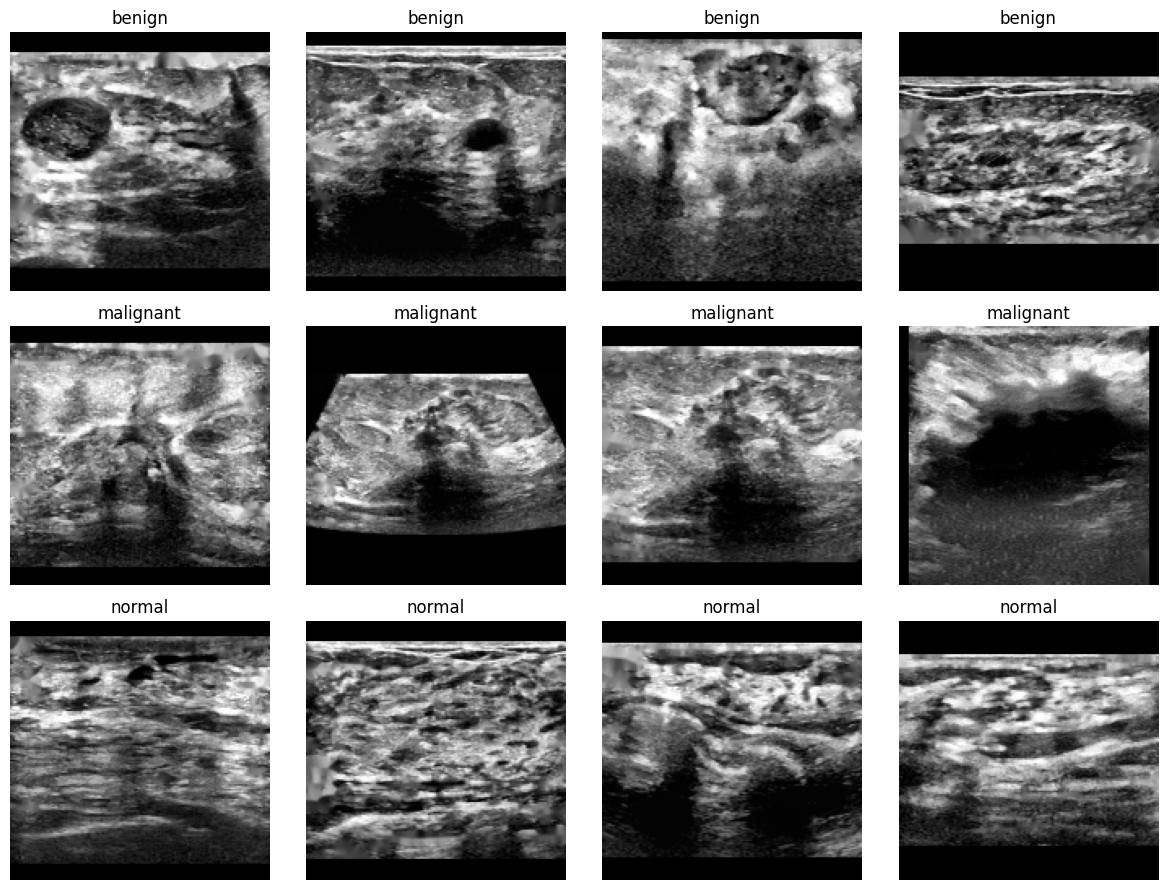

In [ ]:
show_random_grid(OUT_DIR,per_class=4)

In [ ]:
# 📊 4) Conteos por clase y sanity checks del manifiesto
import pandas as pd

df = pd.read_csv(manifest_path)
display(df.head(10))

print("\nConteo por clase:")
print(df["label"].value_counts())

print("\nROI usada (1 sí / 0 no):")
print(df["roi_used"].value_counts())

print("\nCon máscara disponible (no implica que la hayamos usado):")
print(df["has_mask"].value_counts())


orig_path  \
0  /content/Dataset_BUSI_with_GT/benign/benign (2...   
1  /content/Dataset_BUSI_with_GT/benign/benign (9...   
2  /content/Dataset_BUSI_with_GT/benign/benign (3...   
3  /content/Dataset_BUSI_with_GT/benign/benign (3...   
4  /content/Dataset_BUSI_with_GT/benign/benign (1...   
5  /content/Dataset_BUSI_with_GT/benign/benign (2...   
6  /content/Dataset_BUSI_with_GT/benign/benign (1...   
7  /content/Dataset_BUSI_with_GT/benign/benign (4...   
8  /content/Dataset_BUSI_with_GT/benign/benign (3...   
9  /content/Dataset_BUSI_with_GT/benign/benign (2...   

                                            out_path   label  has_mask  \
0  /content/processed_BUSI_160/benign/benign (256...  benign         1   
1  /content/processed_BUSI_160/benign/benign (97)...  benign         1   
2  /content/processed_BUSI_160/benign/benign (344...  benign         1   
3  /content/processed_BUSI_160/benign/benign (350...  benign         1   
4  /content/processed_BUSI_160/benign/benign (148...  benign         1   
5  /content/processed_BUSI_160/benign/benign (287...  benign         1   
6  /content/processed_BUSI_160/benign/benign (123...  benign         1   
7  /content/processed_BUSI_160/benign/benign (406...  benign         1   
8  /content/processed_BUSI_160/benign/benign (383...  benign         1   
9  /content/processed_BUSI_160/benign/benign (239...  benign         1   

   roi_used  img_size  
0         0       160  
1         0       160  
2         0       160  
3         0       160  
4         0       160  
5         0       160  
6         0       160  
7         0       160  
8         0       160  
9         0       160


Conteo por clase:
label
benign       454
malignant    211
normal       133
Name: count, dtype: int64

ROI usada (1 sí / 0 no):
roi_used
0    798
Name: count, dtype: int64

Con máscara disponible (no implica que la hayamos usado):
has_mask
1    780
0     18
Name: count, dtype: int64


label
benign       454
malignant    211
normal       133
Name: count, dtype: int64


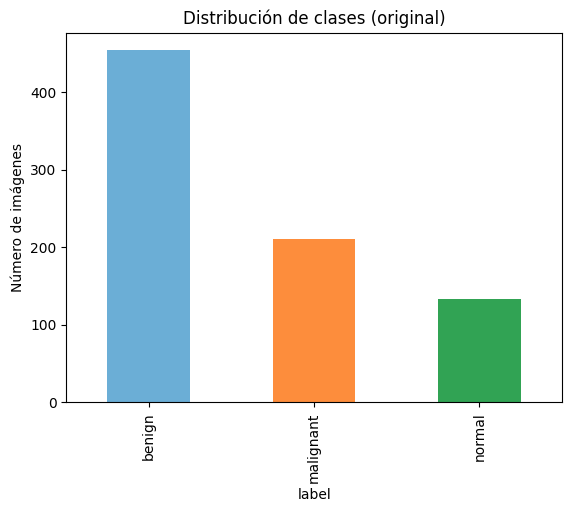

In [ ]:
# ⚙️ 1) Cargar manifiesto y ver distribución
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

df = pd.read_csv(manifest_path)
print(df["label"].value_counts())

# Visualización rápida
df["label"].value_counts().plot(kind="bar", color=["#6BAED6","#FD8D3C","#31A354"])
plt.title("Distribución de clases (original)")
plt.ylabel("Número de imágenes")
plt.show()


In [ ]:
# 🧩 2) Crear splits estratificados (train / val / test)
train_df, test_df = train_test_split(
    df, test_size=0.15, stratify=df["label"], random_state=42
)
train_df, val_df = train_test_split(
    train_df, test_size=0.15, stratify=train_df["label"], random_state=42
)

print("Train:", len(train_df), " | Val:", len(val_df), " | Test:", len(test_df))
print("\nDistribución por conjunto:")
print(pd.concat([
    train_df["label"].value_counts(normalize=True).rename("Train"),
    val_df["label"].value_counts(normalize=True).rename("Val"),
    test_df["label"].value_counts(normalize=True).rename("Test")
], axis=1))


Train: 576  | Val: 102  | Test: 120

Distribución por conjunto:
              Train       Val      Test
label                                  
benign     0.569444  0.568627  0.566667
malignant  0.263889  0.264706  0.266667
normal     0.166667  0.166667  0.166667


In [ ]:
# 🔄 3) Convertir a tf.data.Dataset (Keras) con aumento de datos para balancear
###ejecutar esto antes de build_texture_classifier
import tensorflow as tf
from tensorflow.keras import layers

# Configuración general
BATCH_SIZE = 32
#IMG_SIZE = (IMG_SIZE, IMG_SIZE)  # del preprocesamiento
AUTOTUNE = tf.data.AUTOTUNE

# Diccionario label->id
class_names = sorted(df["label"].unique())
class_to_id = {name:i for i,name in enumerate(class_names)}
print("Clases:", class_to_id)

def load_image_from_path(path, label):
    """
    Lee imagen desde path (ya procesada en RGB 8-bit) y la normaliza a [0,1].
    """
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)  # [0,1]
    return img, tf.one_hot(label, depth=len(class_names))

# Crear datasets
def make_dataset(df_subset, shuffle=True):
    paths = df_subset["out_path"].values
    labels = [class_to_id[l] for l in df_subset["label"]]
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(load_image_from_path, num_parallel_calls=AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds_raw = make_dataset(train_df)
val_ds = make_dataset(val_df, shuffle=False)
test_ds = make_dataset(test_df, shuffle=False)


Clases: {'benign': 0, 'malignant': 1, 'normal': 2}


In [ ]:
# 🧮 4) Crear dataset aumentado para balancear clases minoritarias
# (malignant y normal serán sobre-muestreadas)
class_counts = train_df["label"].value_counts()
max_count = class_counts.max()
print("Conteo por clase:", class_counts.to_dict(), "| Máx =", max_count)

def balance_dataset(df_train, max_count):
    """Duplica/replica aleatoriamente filas de clases con menos muestras."""
    dfs = []
    for cls, subdf in df_train.groupby("label"):
        repeat_n = int(np.ceil(max_count / len(subdf)))
        df_bal = pd.concat([subdf] * repeat_n, ignore_index=True).sample(max_count, random_state=42)
        dfs.append(df_bal)
    return pd.concat(dfs).sample(frac=1, random_state=42).reset_index(drop=True)

train_bal_df = balance_dataset(train_df, max_count)
print(train_bal_df["label"].value_counts())


Conteo por clase: {'benign': 328, 'malignant': 152, 'normal': 96} | Máx = 328
label
malignant    328
normal       328
benign       328
Name: count, dtype: int64


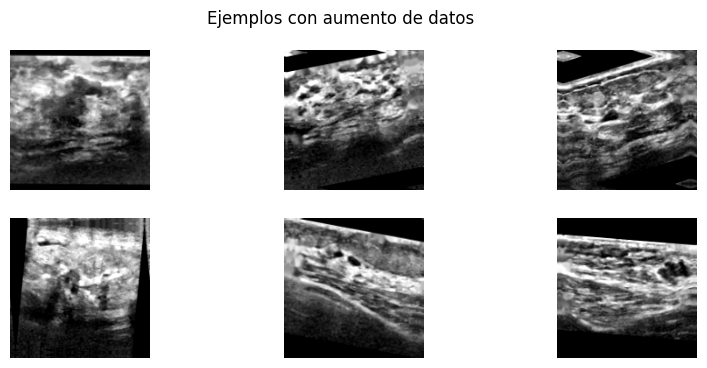

In [ ]:
# 🎨 5) Definir capa de aumento de datos
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.2),
])

# Mostrar ejemplos aumentados
for img_batch, label_batch in make_dataset(train_bal_df).take(1):
    plt.figure(figsize=(10, 4))
    for i in range(6):
        ax = plt.subplot(2, 3, i + 1)
        plt.imshow(data_augmentation(img_batch[i]).numpy())
        plt.axis("off")
    plt.suptitle("Ejemplos con aumento de datos")
    plt.show()


In [ ]:
# ⚙️ 6) Crear datasets finales (aumentado y normalizado)
def make_dataset_aug(df_subset, shuffle=True, augment=False):
    paths = df_subset["out_path"].values
    labels = [class_to_id[l] for l in df_subset["label"]]
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(load_image_from_path, num_parallel_calls=AUTOTUNE)
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                    num_parallel_calls=AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds = make_dataset_aug(train_bal_df, augment=True)
val_ds = make_dataset(val_df)
test_ds = make_dataset(test_df)


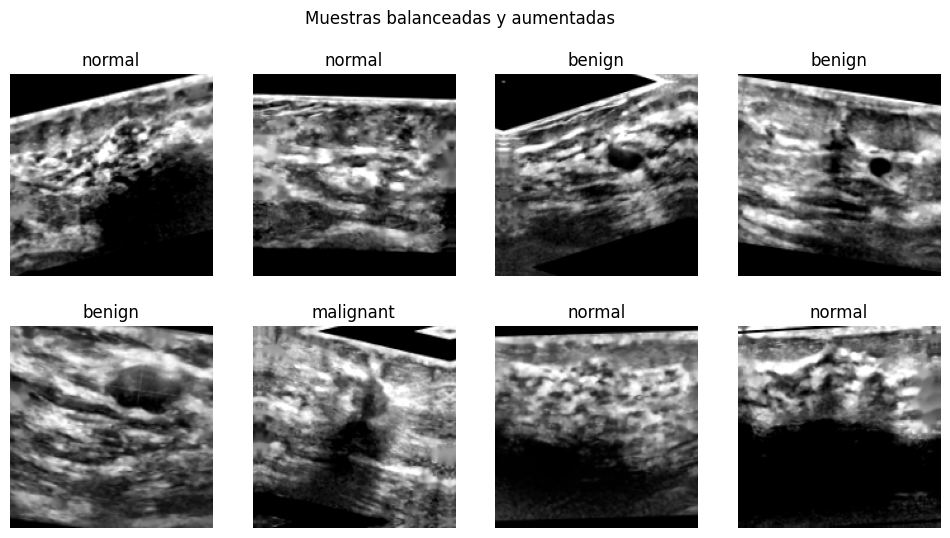

In [ ]:
# 🔍 7) Sanity check visual (muestras del dataset balanceado)
for img_batch, label_batch in train_ds.take(1):
    plt.figure(figsize=(12, 6))
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(img_batch[i].numpy())
        label_idx = tf.argmax(label_batch[i]).numpy()
        plt.title(class_names[label_idx])
        plt.axis("off")
    plt.suptitle("Muestras balanceadas y aumentadas")
    plt.show()


In [ ]:
# # ⚙️ 2) Callbacks estándar
# checkpoint_cb_res = keras.callbacks.ModelCheckpoint(
#     "best_resnet50.keras", monitor="val_accuracy", save_best_only=True
# )
# checkpoint_cb_mob = keras.callbacks.ModelCheckpoint(
#     "best_mobilenetv2.keras", monitor="val_accuracy", save_best_only=True
# )
# early_cb = keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)
# rlrop_cb = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.5)


In [ ]:
# # 🚀 3) Entrenamiento — ResNet50 (freeze) y fine-tuning opcional
# EPOCHS_FREEZE = 6     # entrenamiento con la base congelada
# EPOCHS_FINETUNE = 4   # ajuste fino con últimas capas descongeladas (opcional)

# res_model = build_classifier("resnet50", img_size=160, freeze=True, dropout=0.3)
# res_model.summary()

# hist_res_freeze = res_model.fit(
#     train_ds,
#     validation_data=val_ds,
#     epochs=EPOCHS_FREEZE,
#     callbacks=[checkpoint_cb_res, early_cb, rlrop_cb],
#     verbose=1
# )

# # Fine-tuning (opcional): descongelar últimas capas
# res_model = unfreeze_last_n(res_model, n=40)
# hist_res_ft = res_model.fit(
#     train_ds,
#     validation_data=val_ds,
#     epochs=EPOCHS_FINETUNE,
#     callbacks=[checkpoint_cb_res, early_cb, rlrop_cb],
#     verbose=1
# )


In [ ]:
# ⚙️ Configuración general de entrenamiento
EPOCHS_FREEZE   = 20      # 🧊 entrenamiento base (red congelada)
EPOCHS_FINETUNE = 15      # 🔧 ajuste fino posterior
LR_FREEZE       = 1e-3    # tasa de aprendizaje inicial
LR_FINETUNE     = 1e-4    # tasa durante fine-tuning
UNFREEZE_LAST_N = 40      # capas a descongelar durante fine-tuning

# ✅ Callbacks
from tensorflow import keras

checkpoint_mob = keras.callbacks.ModelCheckpoint(
    "best_mobilenetv2.keras", monitor="val_accuracy", save_best_only=True
)
early_cb = keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)
rlrop_cb = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.5, min_lr=1e-6)

mob_model = build_classifier("mobilenetv2", img_size=IMG_SIZE, freeze=True, dropout=0.3)
mob_model.optimizer.learning_rate.assign(LR_FREEZE)
mob_model.summary()

print(f"\nEntrenando MobileNetV2 (LR={LR_FREEZE}, epochs={EPOCHS_FREEZE})...")
hist_mob_freeze = mob_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_FREEZE,
    callbacks=[checkpoint_mob, early_cb, rlrop_cb],
    verbose=1
)

mob_model = unfreeze_last_n(mob_model, n=UNFREEZE_LAST_N)
mob_model.optimizer.learning_rate.assign(LR_FINETUNE)

print(f"\nFine-tuning MobileNetV2 (últimas {UNFREEZE_LAST_N} capas, LR={LR_FINETUNE}, epochs={EPOCHS_FINETUNE})...")
hist_mob_ft = mob_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_FINETUNE,
    callbacks=[checkpoint_mob, early_cb, rlrop_cb],
    verbose=1
)



/tmp/ipython-input-3780094147.py:24: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = MobileNetV2(include_top=False, input_tensor=x, weights="imagenet")


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "mobilenetv2_clf"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 160, 160,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ preprocess_mobv2    │ (None, 160, 160,  │          0 │ image[0][0]       │
│ (Lambda)            │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ preprocess_mobv2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis

 Total params: 2,261,827 (8.63 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)


Entrenando MobileNetV2 (LR=0.001, epochs=20)...
Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 38s 791ms/step - accuracy: 0.3154 - loss: 1.1420 - val_accuracy: 0.2647 - val_loss: 1.0685 - learning_rate: 0.0010
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 37s 660ms/step - accuracy: 0.3638 - loss: 1.1149 - val_accuracy: 0.3137 - val_loss: 1.1645 - learning_rate: 0.0010
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 41s 649ms/step - accuracy: 0.3712 - loss: 1.1074 - val_accuracy: 0.3333 - val_loss: 1.1252 - learning_rate: 0.0010
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 28s 646ms/step - accuracy: 0.3661 - loss: 1.1040 - val_accuracy: 0.3235 - val_loss: 1.0835 - learning_rate: 0.0010
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 27s 663ms/step - accuracy: 0.4046 - loss: 1.0788 - val_accuracy: 0.2059 - val_loss: 1.0881 - learning_rate: 5.0000e-04
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 42s 679ms/step - accuracy: 0.3693 - loss: 1.0950 - val_accuracy: 0.3627 - val_loss: 1.0757 - learning_rate: 5.0000e-04
Epoch 7/20
31/31 ━━━━━━━━

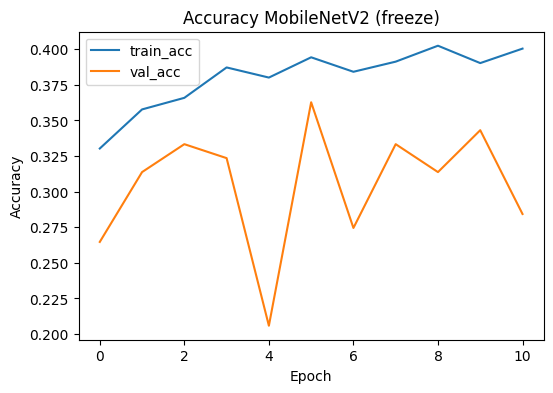

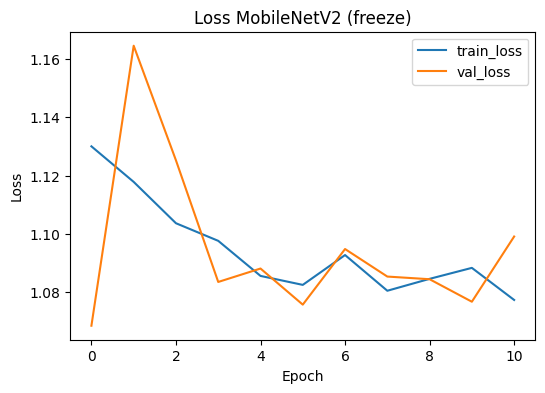

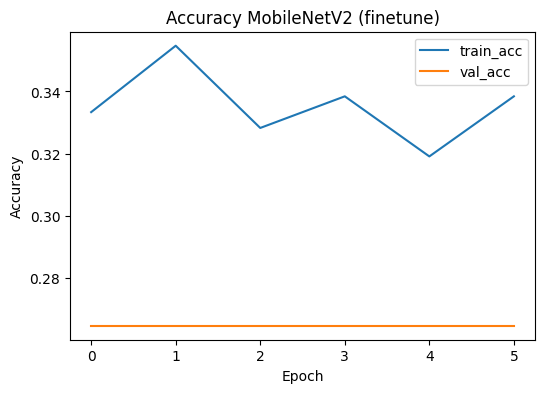

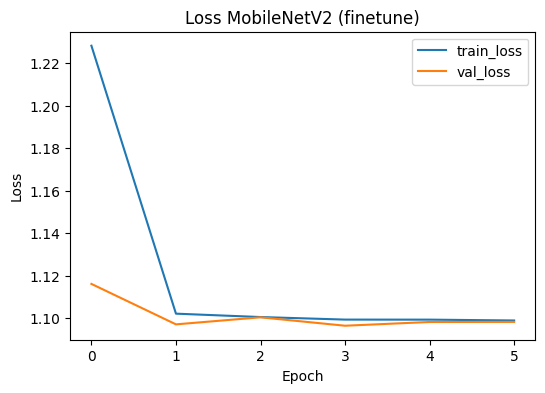

In [ ]:
# 📈 5) Curvas de entrenamiento (accuracy y loss)
import matplotlib.pyplot as plt

def plot_history(hist, title=""):
    h = hist.history
    plt.figure(figsize=(6,4))
    plt.plot(h["accuracy"], label="train_acc")
    plt.plot(h["val_accuracy"], label="val_acc")
    plt.title(f"Accuracy {title}")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(h["loss"], label="train_loss")
    plt.plot(h["val_loss"], label="val_loss")
    plt.title(f"Loss {title}")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.show()

# plot_history(hist_res_freeze, "ResNet50 (freeze)")
# plot_history(hist_res_ft, "ResNet50 (finetune)")
plot_history(hist_mob_freeze, "MobileNetV2 (freeze)")
plot_history(hist_mob_ft, "MobileNetV2 (finetune)")


=== MobileNetV2 (mejor checkpoint) ===
              precision    recall  f1-score   support

      benign     0.6000    0.1765    0.2727        68
   malignant     0.4848    0.5000    0.4923        32
      normal     0.2388    0.8000    0.3678        20

    accuracy                         0.3667       120
   macro avg     0.4412    0.4922    0.3776       120
weighted avg     0.5091    0.3667    0.3471       120



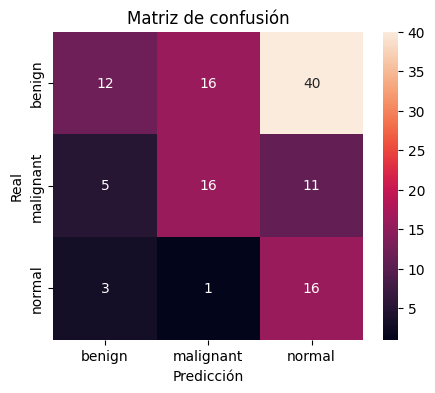

In [ ]:
# ✅ Evaluación en test — corrigendo deserialización de Lambda(preprocess_input)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow import keras
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_pre
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mob_pre

def evaluate_model(model, test_ds, class_names):
    y_true, y_pred = [], []
    for x_batch, y_batch in test_ds:
        probs = model.predict(x_batch, verbose=0)
        y_pred.extend(np.argmax(probs, axis=1))
        y_true.extend(np.argmax(y_batch.numpy(), axis=1))
    y_true = np.array(y_true); y_pred = np.array(y_pred)

    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicción"); plt.ylabel("Real"); plt.title("Matriz de confusión"); plt.show()

def safe_load_model(path, backbone):
    # Mapea la función usada dentro de la Lambda para que Keras la pueda reconstruir
    if backbone == "resnet50":
        co = {"preprocess_input": resnet_pre}
    elif backbone == "mobilenetv2":
        co = {"preprocess_input": mob_pre}
    else:
        co = {}
    return keras.models.load_model(path, custom_objects=co, compile=False)

# print("=== ResNet50 (mejor checkpoint) ===")
# best_resnet = safe_load_model("best_resnet50.keras", backbone="resnet50")
# best_resnet.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
# evaluate_model(best_resnet, test_ds, class_names)

print("=== MobileNetV2 (mejor checkpoint) ===")
best_mob = safe_load_model("best_mobilenetv2.keras", backbone="mobilenetv2")
best_mob.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
evaluate_model(best_mob, test_ds, class_names)


Ejemplo Grad-CAM sobre: /content/processed_BUSI_160/normal/normal (80).png


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['image']]
Received: inputs=['Tensor(shape=(1, 160, 160, 3))']
  warnings.warn(msg)


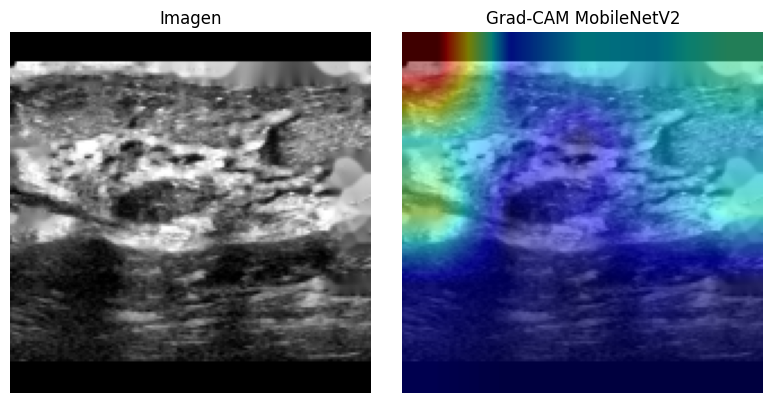

In [ ]:
# 🔎 7) Grad-CAM genérico para inspeccionar qué mira el modelo
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def get_last_conv_layer(model):
    # Busca la última capa con salida 4D (conv featuremap)
    for layer in reversed(model.layers):
        try:
            if len(layer.output.shape) == 4:
                return layer.name
        except Exception:
            continue
    return None

def grad_cam(model, img_tensor, class_index=None, layer_name=None):
    """
    img_tensor: (1, H, W, 3) en [0,1] — OJO: el modelo internamente aplica preprocess_input.
    """
    if layer_name is None:
        layer_name = get_last_conv_layer(model)
        if layer_name is None:
            raise ValueError("No se encontró una capa convolucional adecuada.")

    grad_model = tf.keras.models.Model([model.inputs],
                                       [model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_tensor, training=False)
        if class_index is None:
            class_index = tf.argmax(predictions[0])
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)[0]              # (H, W, C)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))         # (C,)
    conv_outputs = conv_outputs[0]                            # (H, W, C)
    conv_outputs = conv_outputs * pooled_grads
    heatmap = tf.reduce_mean(conv_outputs, axis=-1).numpy()   # (H, W)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= (heatmap.max() + 1e-9)
    return heatmap

def show_gradcam_on_image(model, path, alpha=0.5, title="Grad-CAM"):
    # Cargar imagen procesada del disco (ya está en RGB, [0..255])
    raw = tf.io.read_file(path)
    img = tf.image.decode_png(raw, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)  # [0,1]
    img_resized = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    x = tf.expand_dims(img_resized, axis=0)

    heatmap = grad_cam(model, x, layer_name=None)
    heatmap = tf.image.resize(heatmap[..., None], (IMG_SIZE, IMG_SIZE)).numpy().squeeze()

    base = (img_resized.numpy() * 255).astype("uint8")
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1); plt.imshow(base); plt.title("Imagen"); plt.axis("off")
    plt.subplot(1,2,2); plt.imshow(base); plt.imshow(heatmap, alpha=alpha, cmap="jet")
    plt.title(title); plt.axis("off")
    plt.tight_layout(); plt.show()

# Ejemplo de uso (elige cualquier imagen del manifest de test)
sample_test_path = test_df["out_path"].iloc[0]
print("Ejemplo Grad-CAM sobre:", sample_test_path)
#show_gradcam_on_image(best_resnet, sample_test_path, alpha=0.5, title="Grad-CAM ResNet50")
show_gradcam_on_image(best_mob,   sample_test_path, alpha=0.5, title="Grad-CAM MobileNetV2")


## 🎓 Resultados esperados

- Diferenciar **material** de **textura** con ejemplos.  
- Explicar cómo una **CNN** aprende patrones de textura.  
- Reconocer técnicas como **Bilinear**, **GeM**, **SE/CBAM** o **InstanceNorm**.  
- Proponer estrategias de **datos** para robustecer modelos de textura.

---

## 🔚 Cierre

> En reconocimiento de formas, **la textura no es solo color ni forma**:  
> es una **firma estadística de la apariencia**.  
> Un sistema eficaz combina **datos bien preparados**, **arquitecturas adecuadas**  
> y una **evaluación cuidadosa** ante cambios de iluminación, escala y ruido.